<a href="https://colab.research.google.com/github/Abdul-Subhan24/Netflix-Data-Visualization-ML/blob/main/Netflix_Data_Cleaning%2C_Analysis_and_Visualization_with_ML_Model's.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Netflix Data Analysis & Machine Learning Project

Description:
    This project analyzes Netflix content data, performs exploratory data analysis (EDA),
    builds a recommendation system, forecasts future releases, and classifies content
    type using machine learning.
"""

# =========================
# 1. Import Libraries
# =========================
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from statsmodels.tsa.arima.model import ARIMA

# Use clean style for plots
sns.set_style("whitegrid")


In [ ]:
# =========================
# 2. Load Data
# =========================
df = pd.read_csv("netflix_dataset.csv")  # Replace with your dataset path

In [ ]:
df.head()

,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,9/25/2021,2020,PG-13,90 min,Documentaries
1,s3,TV Show,Ganglands,Julien Leclercq,France,9/24/2021,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act..."
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,9/24/2021,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries"
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,9/22/2021,2021,TV-PG,91 min,"Children & Family Movies, Comedies"
4,s8,Movie,Sankofa,Haile Gerima,United States,9/24/2021,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies"


In [ ]:
# =========================
# 3. Data Cleaning
# =========================
df.drop_duplicates(inplace=True)  # Remove duplicate rows
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')  # Convert to datetime
df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce')  # Ensure year is numeric
df.dropna(subset=['title', 'type', 'listed_in'], inplace=True)  # Remove rows missing important info


df.head()

,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,2021-09-25,2020,PG-13,90 min,Documentaries
1,s3,TV Show,Ganglands,Julien Leclercq,France,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act..."
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,2021-09-24,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries"
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,2021-09-22,2021,TV-PG,91 min,"Children & Family Movies, Comedies"
4,s8,Movie,Sankofa,Haile Gerima,United States,2021-09-24,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies"


In [ ]:
# =========================
# 4. Feature Engineering
# =========================
# Number of genres for each title
df['num_genres'] = df['listed_in'].apply(lambda x: len(x.split(', ')) if pd.notnull(x) else 0)

# Extract numeric duration (for movies: minutes, for TV shows: seasons)
def convert_duration(dur):
    try:
        return int(str(dur).split()[0])
    except:
        return None
df['duration_numeric'] = df['duration'].apply(convert_duration)

# Year & month when content was added to Netflix
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

# Binary target: 0 = Movie, 1 = TV Show
df['is_tv_show'] = df['type'].apply(lambda x: 1 if x == 'TV Show' else 0)


df.head()

,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in,num_genres,duration_numeric,year_added,month_added,is_tv_show
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,2021-09-25,2020,PG-13,90 min,Documentaries,1,90,2021,9,0
1,s3,TV Show,Ganglands,Julien Leclercq,France,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",3,1,2021,9,1
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,2021-09-24,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries",3,1,2021,9,1
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,2021-09-22,2021,TV-PG,91 min,"Children & Family Movies, Comedies",2,91,2021,9,0
4,s8,Movie,Sankofa,Haile Gerima,United States,2021-09-24,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies",3,125,2021,9,0


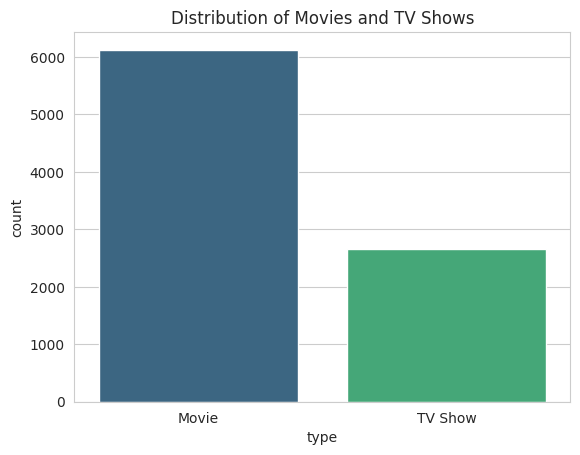

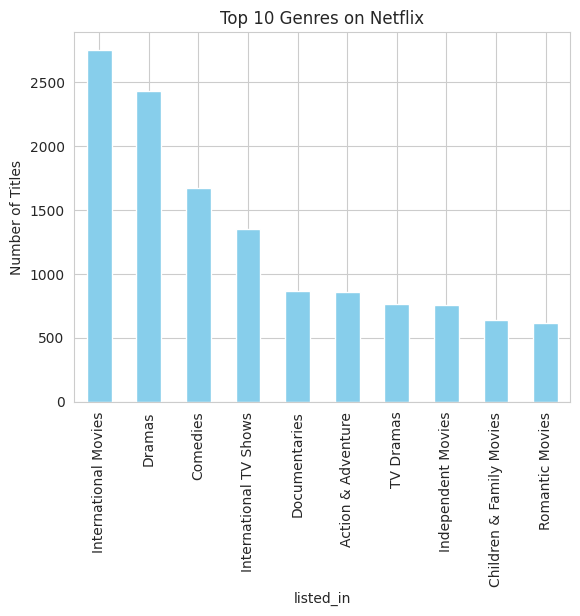

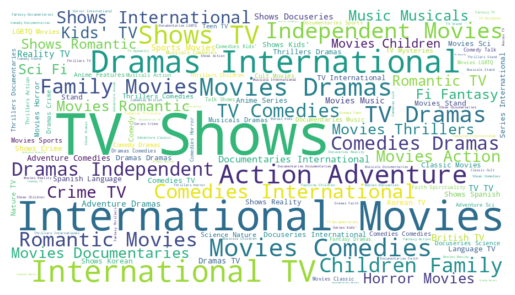

In [ ]:
# =========================
# 5. Exploratory Data Analysis (EDA)
# =========================
os.makedirs("outputs", exist_ok=True)

# Movies vs TV Shows distribution
sns.countplot(x='type', data=df, palette='viridis')
plt.title("Distribution of Movies and TV Shows")
plt.savefig("outputs/type_distribution.png")
plt.show()
plt.close()

# Top 10 genres
top_genres = df['listed_in'].str.split(', ').explode().value_counts().head(10)
top_genres.plot(kind='bar', color='skyblue')
plt.title("Top 10 Genres on Netflix")
plt.ylabel("Number of Titles")
plt.savefig("outputs/top_genres.png")
plt.show()
plt.close()

# Word cloud of genres
wordcloud = WordCloud(width=900, height=500, background_color='white').generate(" ".join(df['listed_in']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("outputs/genre_wordcloud.png")
plt.show()
plt.close()

In [ ]:
# =========================
# 6. Recommendation System
# =========================
# Combine genres & director
df['features'] = df['listed_in'] + " " + df['director'].fillna('')

# Convert to matrix
cv = CountVectorizer()
count_matrix = cv.fit_transform(df['features'])

# Cosine similarity
cosine_sim = cosine_similarity(count_matrix)

def recommend(title, num=5):
    """Returns a list of similar titles."""
    if title not in df['title'].values:
        return f"'{title}' not found."
    idx = df[df['title'] == title].index[0]
    scores = list(enumerate(cosine_sim[idx]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)[1:num+1]
    return df['title'].iloc[[i[0] for i in scores]].tolist()

# Example
print("Recommendations for 'Ganglands':", recommend("Ganglands"))

Recommendations for 'Ganglands': ['Bangkok Breaking', "The Eagle of El-Se'eed", 'The Truth', 'Fatal Destiny', 'Nowhere Man']


Forecast for next 5 years:
 74    328.420826
75    126.338231
76    -28.595768
77   -147.381574
78   -238.453049
Name: predicted_mean, dtype: float64


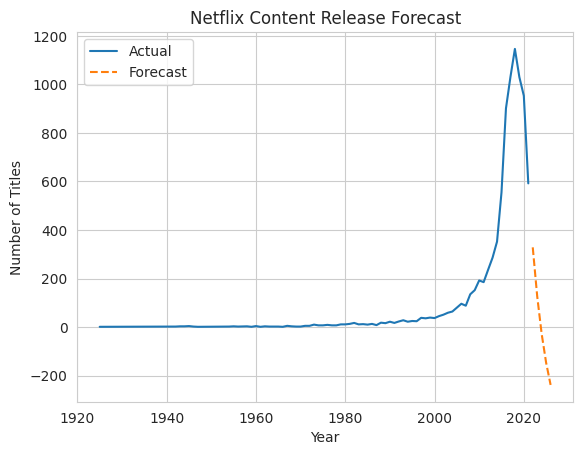

In [ ]:
# =========================
# 7. Forecasting with ARIMA
# =========================
# Count releases per year
yearly_counts = df.groupby('release_year').size()
yearly_counts = yearly_counts[yearly_counts.index.notnull()]  # Remove NaN years

# Fit ARIMA model
model = ARIMA(yearly_counts, order=(1, 1, 1))
model_fit = model.fit()

# Forecast next 5 years
forecast = model_fit.forecast(steps=5)
print("Forecast for next 5 years:\n", forecast)

# Plot forecast
plt.plot(yearly_counts.index, yearly_counts.values, label='Actual')
plt.plot(range(yearly_counts.index.max()+1, yearly_counts.index.max()+6), forecast, label='Forecast', linestyle='--')
plt.title("Netflix Content Release Forecast")
plt.xlabel("Year")
plt.ylabel("Number of Titles")
plt.legend()
plt.savefig("outputs/forecast.png")
plt.show()
plt.close()

In [ ]:
# =========================
# 8. Random Forest Classification
# =========================
# Features & target
X = df[['duration_numeric', 'num_genres', 'year_added', 'month_added']].fillna(0)
y = df['is_tv_show']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions & evaluation
y_pred = rf.predict(X_test)
print("Random Forest Accuracy:", rf.score(X_test, y_test))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Movie vs TV Show)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("outputs/confusion_matrix.png")
plt.close()

Random Forest Accuracy: 0.9973454683352294
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1857
           1       0.99      1.00      1.00       780

    accuracy                           1.00      2637
   macro avg       1.00      1.00      1.00      2637
weighted avg       1.00      1.00      1.00      2637

